# Store Sales
## Time Serias Forecast & Visualization

In this [kaggle competition](https://www.kaggle.com/c/store-sales-time-series-forecasting/overview), we’ll use time-series forecasting to forecast store sales on data from _Corporación Favorita_, a large Ecuadorian-based grocery retailer. 

Our goal is to predict unit sales for each store and item family for 16 days next to our historical data.

In [1]:
# import libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection, linear_model, metrics, tree, ensemble
from datetime import date, timedelta
import xgboost as xgb

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.signal import periodogram

import seaborn as sns
%pylab inline 

from itertools import product

from warnings import filterwarnings
filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def rmsle(y_true, y_pred):
    diffs = np.log(y_true + 1) - np.log(y_pred + 1) 
    squares = np.power(diffs, 2)
    err = np.sqrt(np.mean(squares))
    return err

In [3]:
def plot_periodogram(ts, detrend='linear', ax=None):
    
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")  # 365
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [4]:
plot_params = {'color':'0.75', 'style':'.-', 'markeredgecolor':'0.25', 'markerfacecolor':'0.25', 'legend':False}
MSE = metrics.mean_squared_error
MAE = metrics.mean_absolute_error

# 1. Data Load

In [5]:
df_train = pd.read_csv('train.csv', index_col='id')
df_test = pd.read_csv('test.csv', index_col='id')
df_hol = pd.read_csv('holidays_events.csv')
df_oil = pd.read_csv('oil.csv')
df_stores = pd.read_csv('stores.csv')

In [6]:
display(df_train.head(3))
display(df_test.head(3))
print(f"train data period from: {df_train['date'].min()} to {df_train['date'].max()}")
print(f"test data period from: {df_test['date'].min()} to {df_test['date'].max()}")

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,2013-01-01,1,BABY CARE,0.0,0.0
2,2013-01-01,1,BEAUTY,0.0,0.0


,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,20.0
3000889,2017-08-16,1,BABY CARE,1.0
3000890,2017-08-16,1,BEAUTY,8.0


train data period from: 2013-01-01 to 2017-08-15
test data period from: 2017-08-16 to 2017-08-31


In [7]:
display(df_hol.head(3))
display(df_oil.head(3))
display(df_stores.head(3))
print(f"oil data period from: ,{df_oil['date'].min()} to {df_oil['date'].max()}")
print(f"holidays data period from: {df_hol['date'].min()} to {df_hol['date'].max()}")

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8


oil data period from: ,2013-01-01 to 2017-08-31
holidays data period from: 2012-03-02 to 2017-12-26


# 2. Feature Extraction & Engineering

**holidays_events** description

Holidays and Events, with metadata

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [8]:
print('Number of unique events/ holidays: ', len(df_hol.description.unique()))

Number of unique events/ holidays:  103


There are 103 different types of events and holidays. Let's make this classification more simply.

In [9]:
# add terremoto feature
df_hol.loc[df_hol['description'].str.startswith('Terremoto'), 'terremoto'] = 1

# keep only unworking holiday days and events
df_hol.drop(df_hol[(df_hol['type']=='Work Day') | 
                   ((df_hol['type']=='Holiday') & (df_hol['transferred']==True))].index, inplace=True)

# add national event
df_hol.loc[(df_hol['type']=='Event') & (df_hol['terremoto']!=True), 'event_national'] = 1

# add national holiday
df_hol.loc[(df_hol['type']!='Event') & (df_hol['locale']=='National'), 'holiday_national'] = 1

# add regional holiday
df_hol.loc[(df_hol['type']!='Event') & (df_hol['locale']=='Regional'), 'holiday_regional'] = 1

# add local holiday
df_hol.loc[(df_hol['type']!='Event') & (df_hol['locale']=='Local'), 'holiday_local'] = 1

df_hol.head(3)

,date,type,locale,locale_name,description,transferred,terremoto,event_national,holiday_national,holiday_regional,holiday_local
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,NaN,NaN,NaN,NaN,1.0
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,NaN,NaN,NaN,1.0,NaN
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,NaN,NaN,NaN,NaN,1.0


In [10]:
# Add more features to our train data

# add cities 
data_train = df_train.merge(
    df_stores[['city', 'state', 'type', 'cluster','store_nbr']], on=['store_nbr'], how = 'left')

# add terremoto feature
data_train = data_train.merge(
    df_hol[df_hol['terremoto']==True][['date','terremoto']], on = ['date'], how = 'left')

# add national events
data_train = data_train.merge(
    df_hol[df_hol['event_national']==True][['date', 'event_national']], on = ['date'], how = 'left')

# add national holidays 
data_train = data_train.merge(
    df_hol[df_hol['holiday_national']==True][['date', 'holiday_national']], on = ['date'], how = 'left')

# add regional holidays
data_train = data_train.merge(
    df_hol[df_hol['holiday_regional']==True][['date','holiday_regional', 'locale_name']], 
    left_on = ['date', 'state'], right_on = ['date', 'locale_name'], how = 'left')

# add local holidays
data_train = data_train.merge(
    df_hol[df_hol['holiday_local']==True][['date','holiday_local', 'locale_name']], 
                              left_on = ['date', 'city'], right_on = ['date', 'locale_name'], how = 'left')

data_train.drop_duplicates(ignore_index=True, inplace=True)

There are 3 levels of hoildays: National(Ecuador) --> Regional(state) --> Local(city). Let's simplify our holiday classification even more to get only one _holiday_ column if any of this holidays is present. 

In [11]:
# marks as holiday if there is at least 1 holiday
data_train.loc[
    (data_train['holiday_national']==1)|(data_train['holiday_regional']==1)|(data_train['holiday_local']==1),
    'holiday'] = 1

data_train.drop(columns=['holiday_national', 'holiday_regional', 'holiday_local', 
                         'locale_name_x', 'locale_name_y', 'state'], inplace=True)

# fill the gaps
data_train.fillna(0, inplace=True)

In [12]:
# add oil prices

data_train = data_train.merge(df_oil, on = ['date'], how = 'left')
data_train['dcoilwtico'].fillna(method='bfill', inplace=True)

Additional Note.

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

So, we add also _payday_ feature.

In [13]:
# format date
data_train['date'] = pd.to_datetime(data_train['date'], errors='coerce')

# add pay day 
data_train.loc[(data_train['date'].dt.day==15)|(data_train['date'].dt.is_month_end),'payday'] = 1
data_train['payday'].fillna(0, inplace=True)

data_train.head(3)

,date,store_nbr,family,sales,onpromotion,city,type,cluster,terremoto,event_national,holiday,dcoilwtico,payday
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,D,13,0.0,0.0,1.0,93.14,0.0
1,2013-01-01,1,BABY CARE,0.0,0.0,Quito,D,13,0.0,0.0,1.0,93.14,0.0
2,2013-01-01,1,BEAUTY,0.0,0.0,Quito,D,13,0.0,0.0,1.0,93.14,0.0


# 3. Average Sales EDA

In [14]:
mean_sales = data_train[['date', 'sales', 'terremoto', 'event_national', 'dcoilwtico', 'payday', 'onpromotion']]\
                        .groupby(['date']).mean().reset_index()
mean_sales.head(3)

,date,sales,terremoto,event_national,dcoilwtico,payday,onpromotion
0,2013-01-01,1.409438,0.0,0.0,93.14,0.0,0.0
1,2013-01-02,278.390807,0.0,0.0,93.14,0.0,0.0
2,2013-01-03,202.840197,0.0,0.0,92.97,0.0,0.0


In [15]:
# Check missed days in train data

miss_dates = []
for i in range(1, mean_sales.shape[0]):
    if (mean_sales.iloc[i, 0] - mean_sales.iloc[i-1, 0]).days > 1:
        miss_dates.append(mean_sales.iloc[i-1, 0]+ timedelta(days=1))
print('missed dates:') 
miss_dates

missed dates:


[Timestamp('2013-12-25 00:00:00'),
 Timestamp('2014-12-25 00:00:00'),
 Timestamp('2015-12-25 00:00:00'),
 Timestamp('2016-12-25 00:00:00')]

In [16]:
# Add absent days
       
df1_miss = pd.DataFrame(data={'date': miss_dates})

mean_sales = pd.concat([mean_sales, df1_miss], axis=0)
mean_sales.sort_values('date', inplace=True, ignore_index=True)
mean_sales['dcoilwtico'].fillna(method='bfill', inplace=True)
mean_sales.fillna(0.0, inplace=True)
mean_sales.head(3)

,date,sales,terremoto,event_national,dcoilwtico,payday,onpromotion
0,2013-01-01,1.409438,0.0,0.0,93.14,0.0,0.0
1,2013-01-02,278.390807,0.0,0.0,93.14,0.0,0.0
2,2013-01-03,202.840197,0.0,0.0,92.97,0.0,0.0


In [17]:
# add time dummy
mean_sales['date_number'] = mean_sales.index

n_ticks = []
dates_ticks = []
i = 0
for n in range(mean_sales.shape[0]):
    while i <= n:
        n_ticks.append(mean_sales.loc[i, 'date_number'])
        dates_ticks.append(mean_sales.loc[i, 'date'])
        i = i+365

### Sales vs. Oil prices

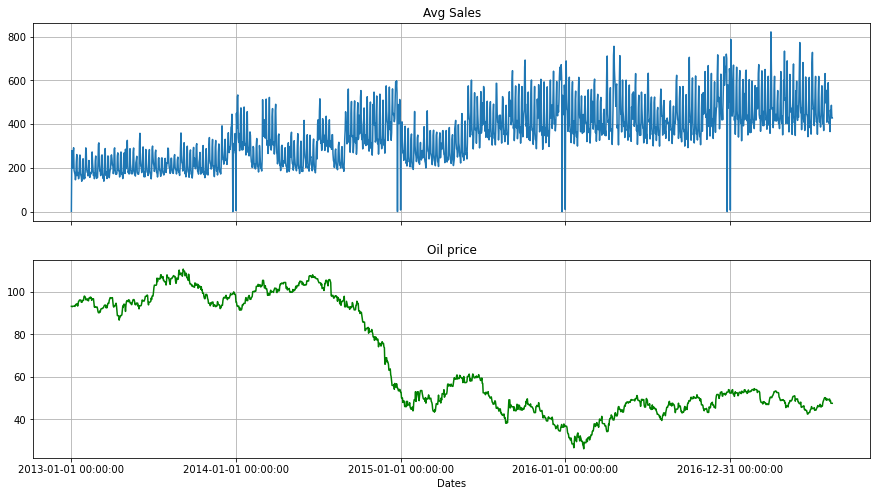

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8), sharex=True)
      
ax[0].plot('date_number', 'sales', data=mean_sales)
ax[0].grid()
ax[0].set_title('Avg Sales')
ax[1].plot('date_number', 'dcoilwtico', data=mean_sales, color='g')
ax[1].grid()
ax[1].set_xticks(n_ticks)
ax[1].set_xticklabels(dates_ticks)
ax[1].set_xlabel('Dates')
ax[1].set_title('Oil price');

### Sales vs. Onpromotion

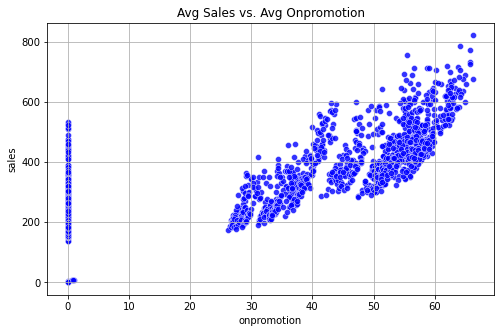

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x='onpromotion', y='sales', data=mean_sales, color='b', alpha=0.8)
ax.grid(True)
ax.set_xlabel('onpromotion')
ax.set_ylabel('sales')
ax.set_title('Avg Sales vs. Avg Onpromotion');

### Sales vs. Terremoto, Event_national, Payday

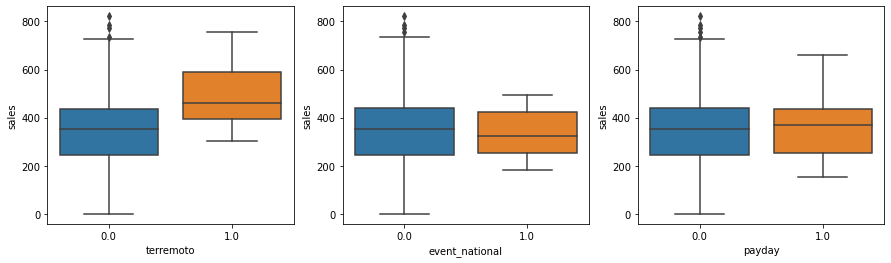

In [20]:
binary_features = ['terremoto', 'event_national', 'payday']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
for idx, feature in enumerate(binary_features):
    sns.boxplot(mean_sales[feature], mean_sales['sales'], ax=axes[idx %3]);

It seems, with decreasing of *oil price*, mean *sales* were encreasing. Also, there is strong correlation between average *sales* and average *onpromotion*. The terremoto event also affectes to average *sales* increasing. Meanwhile, it seems there are no difference between *sales* and *event_national*  or *payday* as well. But, we need to remember, we are analyzing the *average* prices, in the family/store context the view can be different.

# 4. Trend and Seasonality as features

First, we will use the regression plots to determinate the order of trend fitted to mean sales. Also, the periodogram will help to define seasonality in our time series.

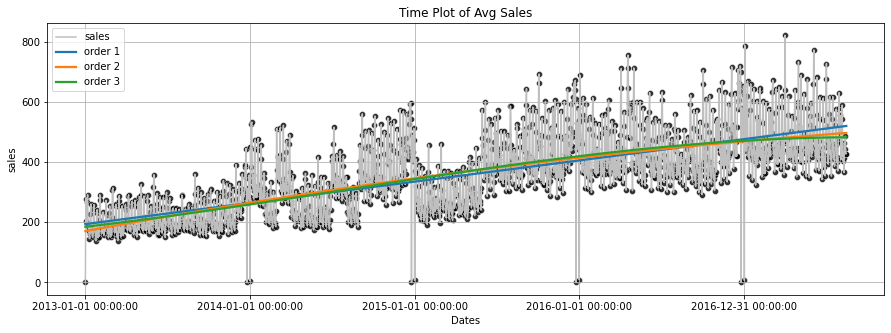

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))
      
ax.plot('date_number', 'sales', data=mean_sales, color='0.75')
ax = sns.scatterplot(x='date_number', y='sales', data=mean_sales, color='k', alpha=0.8)
ax = sns.regplot(x='date_number', y='sales', data=mean_sales, ci=None, order=1, scatter=False, label='order 1')
ax = sns.regplot(x='date_number', y='sales', data=mean_sales, ci=None, order=2, scatter=False, label='order 2')
ax = sns.regplot(x='date_number', y='sales', data=mean_sales, ci=None, order=3, scatter=False, label='order 3')
ax.grid()
ax.legend()
ax.set_xticks(n_ticks)
ax.set_xticklabels(dates_ticks)
ax.set_xlabel('Dates')
ax.set_title('Time Plot of Avg Sales');

In [22]:
mean_sales[mean_sales['sales']<10]

,date,sales,terremoto,event_national,dcoilwtico,payday,onpromotion,date_number
0,2013-01-01,1.409438,0.0,0.0,93.14,0.0,0.000000,0
358,2013-12-25,0.000000,0.0,0.0,99.18,0.0,0.000000,358
365,2014-01-01,4.827197,0.0,0.0,95.14,0.0,0.000000,365
723,2014-12-25,0.000000,0.0,0.0,54.59,0.0,0.000000,723
730,2015-01-01,7.168135,0.0,0.0,52.72,0.0,0.659933,730
1088,2015-12-25,0.000000,0.0,0.0,36.36,0.0,0.000000,1088
1095,2016-01-01,9.221882,0.0,0.0,36.81,0.0,0.964085,1095
1454,2016-12-25,0.000000,0.0,0.0,52.82,0.0,0.000000,1454
1461,2017-01-01,6.780304,0.0,0.0,52.36,0.0,0.950056,1461


In [23]:
# add new year special holidays
mean_sales.loc[((mean_sales['date'].dt.strftime("%Y-%m-%d")).str.endswith('-12-25')|\
              (mean_sales['date'].dt.strftime("%Y-%m-%d")).str.endswith('-01-01')),
              'new_year'] = 1
mean_sales.fillna(0, inplace=True)

We can observe the strong sales drops (the sales are null or almost null) in certain dates. It could become an outlier for our train data, but we can't simply drop it, as we working with time series data. It's clear that such falls occurs in 2 kinds of dates, "New Year" and "Christmas". We just add new feature for these dates. 

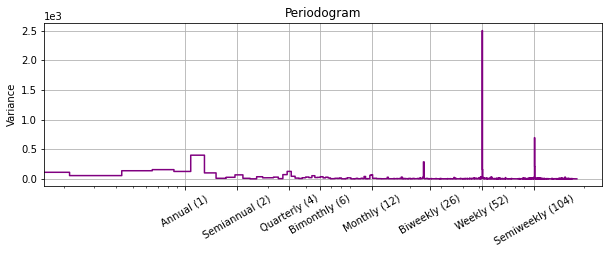

In [24]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_periodogram(mean_sales['sales'], ax=ax)
pylab.grid();

Now, we can model the seasonality and trend features using Fourier components. According to the periodogram, there is strong weekly and weaker annual seasonality, so we add corresponding Fourier compoments to the model. The polynomial trend seems to be of the 3rd order. With our feature set created, we can fit the model and make predictions.

In [25]:
mean_sales['date'] = mean_sales['date'].dt.to_period('D')
mean_sales.set_index('date', inplace=True)
y_mean = mean_sales['sales']

In [26]:
fourier1 = CalendarFourier(freq='M', order=4)    # 4 Fourier components per month
fourier2 = CalendarFourier(freq='W', order=7)    # 7 Fourier components  per week
fourier3 = CalendarFourier(freq='A', order=12)   # 12 Fourier components per year

dp = DeterministicProcess(
    index=y_mean.index,
    constant=True,
    order=3,                                      # trend 
    additional_terms=[fourier1, fourier2, fourier3],
    drop=True,
)
X_dp = dp.in_sample()
X_dp = X_dp.join(mean_sales[['new_year']])

In [27]:
split_ind = X_dp.shape[0]-30                      # 30 days for validation data

y_mean_train = y_mean.iloc[:split_ind]
y_mean_val = y_mean.iloc[split_ind:]
X_dp_train = X_dp.iloc[:split_ind, :]
X_dp_val = X_dp.iloc[split_ind:, :]

model_dp = linear_model.LinearRegression(normalize=True).fit(X_dp_train, y_mean_train)

y_mean_fit = pd.Series(model_dp.predict(X_dp_train), index=X_dp_train.index)
y_mean_pred = pd.Series(model_dp.predict(X_dp_val), index=X_dp_val.index)

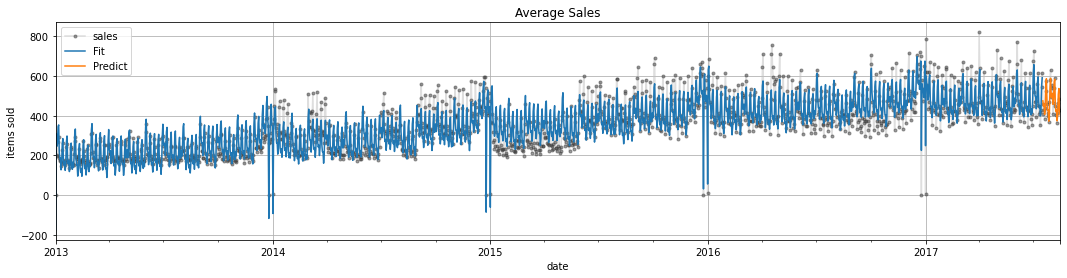

In [28]:
fig, ax = plt.subplots(figsize=(18, 4))
ax = y_mean.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_mean_fit.plot(ax=ax, label="Fit")
ax = y_mean_pred.plot(ax=ax, label="Predict")
ax.grid()
ax.legend();

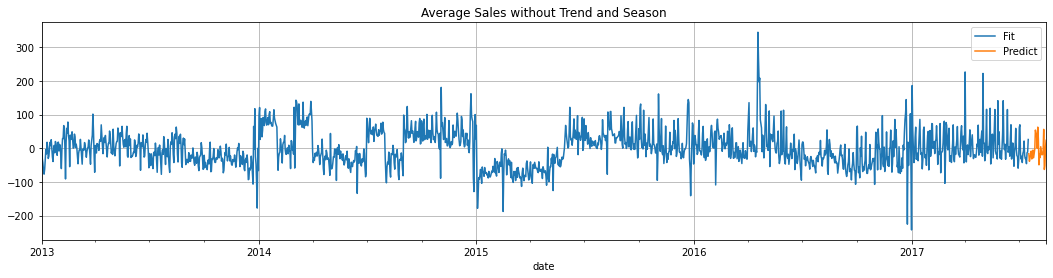

In [29]:
fig, ax = plt.subplots(figsize=(18, 4))
ax = (y_mean-y_mean_fit).plot(ax=ax, label="Fit")
ax = (y_mean-y_mean_pred).plot(ax=ax, label="Predict")
ax.grid()
ax.set_title("Average Sales without Trend and Season")
ax.legend();

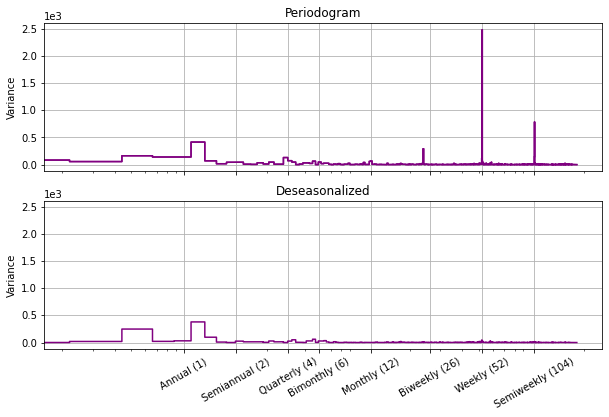

In [30]:
y_mean_deseason = y_mean_train - y_mean_fit

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 6))
ax1 = plot_periodogram(y_mean_train, ax=ax1)
ax1.grid()
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_mean_deseason, ax=ax2);
ax1 = plot_periodogram(y_mean_train, ax=ax1)
ax2.grid()
ax2.set_title("Deseasonalized");

After trend and seasonal modelied components elimination, the weak annual seasonality still maintains. That could be happened because of some no deterministic behavior in our data.

We've just seen that the Linear Regresson is pretty good to predict polynomical trend with seasonal components. While it's known that tree based algotithms like Random Forest or XGBoost are unable to learn trend (as they can't predit extrapolation values of function). So, we will use the hybrid model to predict trend using Linear Regression and tree methods after elimination such trend.

# 5. Model fitting

## 5.1. Linear Regression Model

In [31]:
# sales by store and family
store_sales = data_train[['date', 'store_nbr', 'family', 'sales']]
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
y_dp = store_sales.unstack(['store_nbr', 'family'])
y_dp.head(3)

sales                                                \
store_nbr          1                                                  
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   

                                                 ...                    \
store_nbr                                        ...        54           
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0   0.000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  73.771   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  50.257   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01           0.0          0.0                     0.0   0.000   
2013-01-02         228.0          0.0                     0.0  15.514   
2013-01-03         156.0          0.0                     0.0   4.313   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02           61.0     0.0                        0.0     3.0  
2013-01-03            1.0     0.0                        0.0     2.0  

[3 rows x 1782 columns]

In [32]:
# create df with missed dates
df2_miss = pd.DataFrame(data=None, index=miss_dates, columns=y_dp.columns, dtype=None, copy=None)
df2_miss.fillna(0, inplace=True)
df2_miss.index= df2_miss.index.to_period('D')
df2_miss.index.name='date'

# add missed dates
y_dp = pd.concat([y_dp, df2_miss], axis=0) 
y_dp.sort_values('date', inplace=True)

In [33]:
# Create modelied training data
fourier1 = CalendarFourier(freq='M', order=4)    # 4 Fourier components per month
fourier2 = CalendarFourier(freq='W', order=7)    # 7 Fourier components  per week
fourier3 = CalendarFourier(freq='A', order=12)   # 12 Fourier components per year


dp = DeterministicProcess(
    index=y_dp.index,
    constant=True,
    order=3,                                      # trend 
    additional_terms=[fourier1, fourier2, fourier3],
    drop=True,
)
X_dp = dp.in_sample()
X_dp = X_dp.join(mean_sales[['new_year']])       # add special holiday

split_ind = X_dp.shape[0]-30                     # 30 days for validation
y_dp_train = y_dp.iloc[:split_ind]
y_dp_val = y_dp.iloc[split_ind:]

X_dp_train = X_dp.iloc[:split_ind, :]
X_dp_val = X_dp.iloc[split_ind:, :]

In [34]:
model_dp = linear_model.LinearRegression(fit_intercept=False, normalize=True)
model_dp.fit(X_dp_train, y_dp_train)

y_dp_fit = pd.DataFrame(model_dp.predict(X_dp_train), index=X_dp_train.index, columns=y_dp.columns)
y_dp_pred = pd.DataFrame(model_dp.predict(X_dp_val), index=X_dp_val.index, columns=y_dp.columns)

In [35]:
# get item families with higher sales
family_top15 = store_sales.reset_index().groupby(['family']).mean().sort_values(by='sales', ascending=False).\
                head(15).index

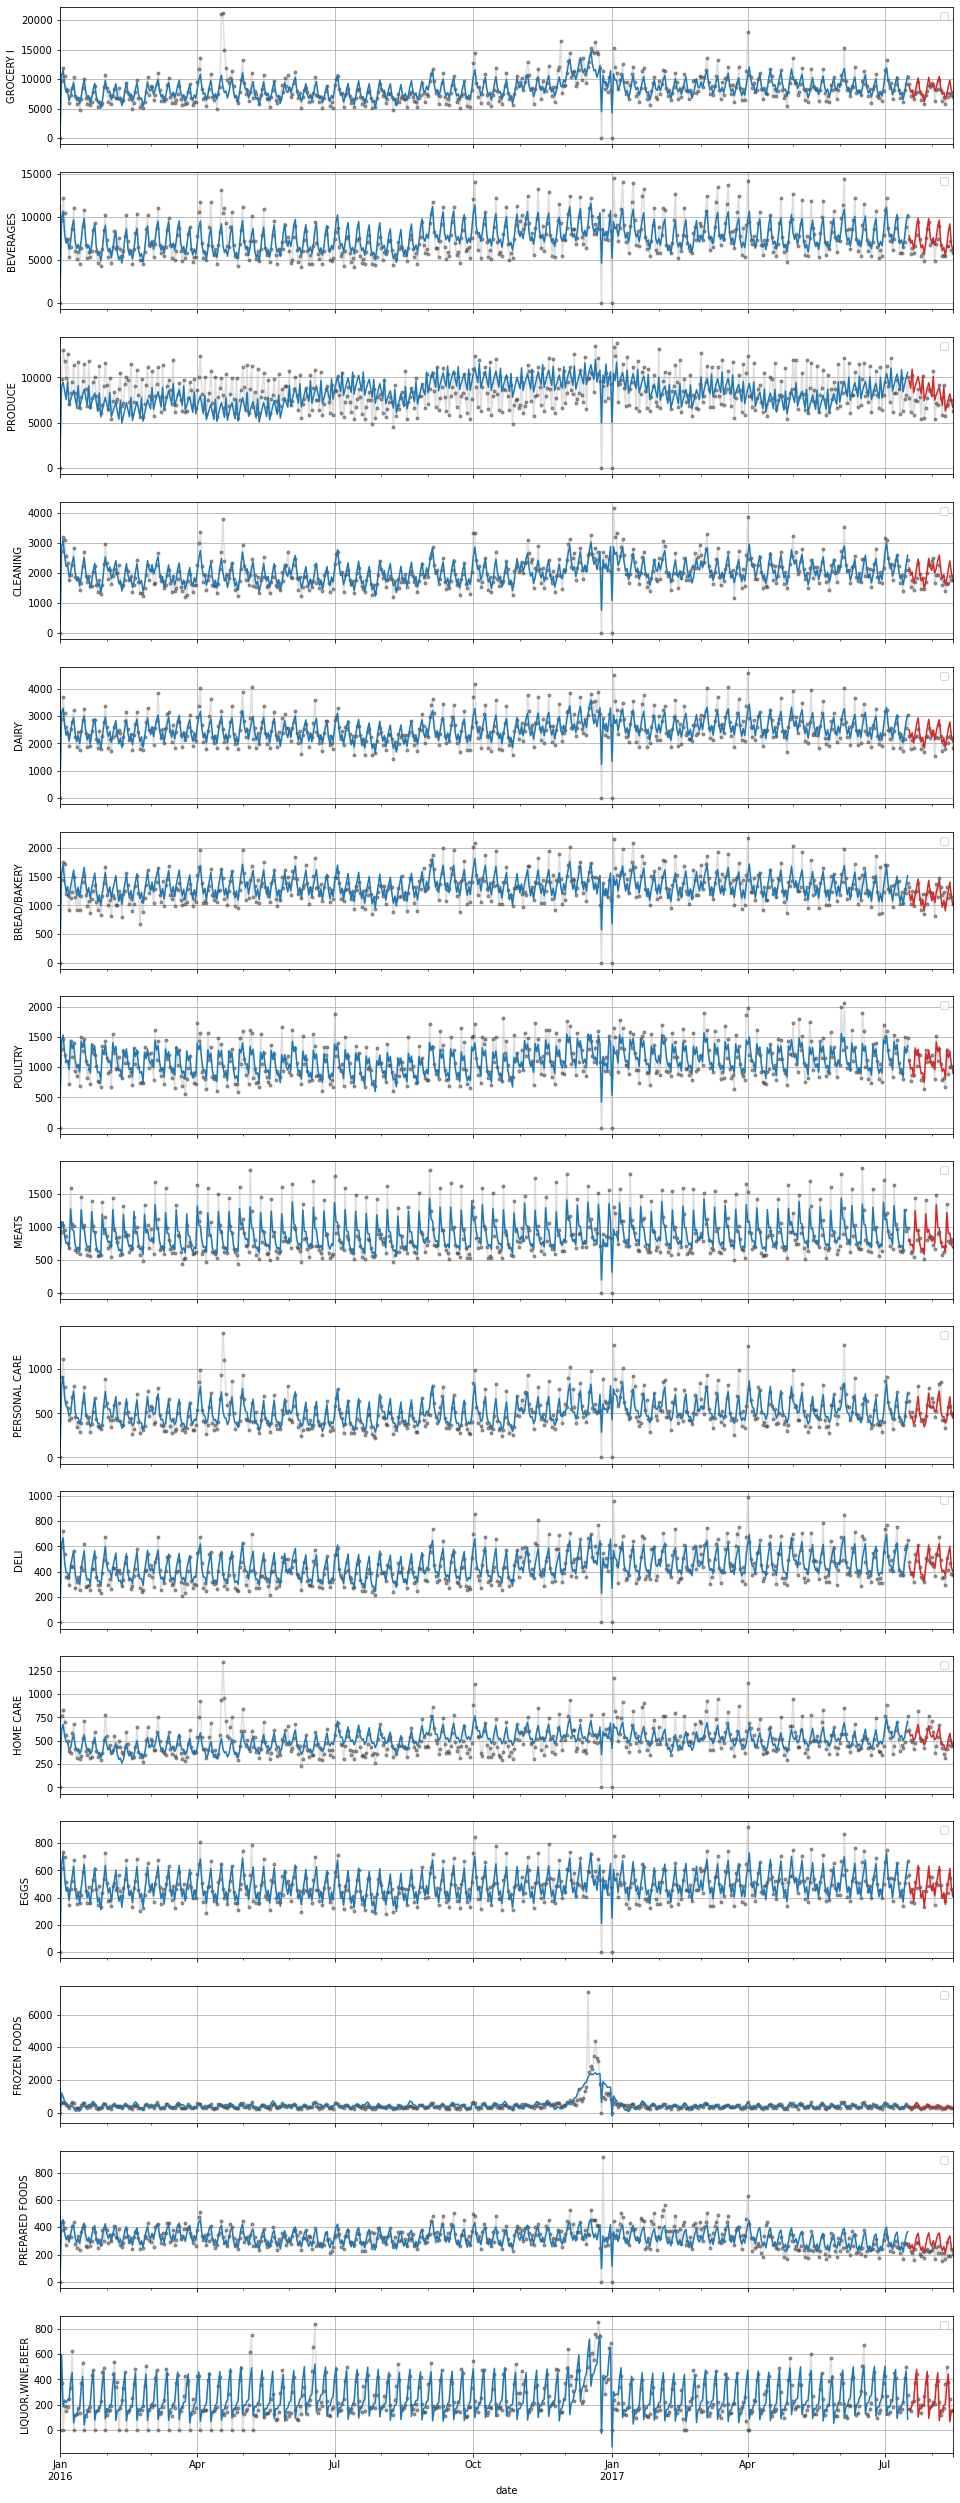

In [36]:
# Visualization for top sales
STORE_NBR = 49  
axs = y_dp['2016-01-01':].loc(axis=1)['sales', STORE_NBR, family_top15].\
      plot(subplots=True, sharex=True, figsize=(16, 3*len(family_top15)), **plot_params, alpha=0.5)
_ = y_dp_fit['2016-01-01':].loc(axis=1)['sales', STORE_NBR, family_top15].\
    plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_dp_pred['2016-01-01':].loc(axis=1)['sales', STORE_NBR, family_top15].\
    plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, family_top15):
    ax.legend([])
    ax.grid()
    ax.set_ylabel(family)   

In [37]:
print(f'rmsle \ntrain:{rmsle(y_dp_train, y_dp_fit).mean()}, test: {rmsle(y_dp_val, y_dp_pred).mean()}')
print(f'MSE \ntrain:{MSE(y_dp_train, y_dp_fit).mean()}, test: {MSE(y_dp_val, y_dp_pred).mean()}')
print(f'MAE \ntrain:{MAE(y_dp_train, y_dp_fit).mean()}, test: {MAE(y_dp_val, y_dp_pred).mean()}')

rmsle 
train:0.8674311371216681, test: 0.4423493900482852
MSE 
train:100899.86380047332, test: 70950.58598478173
MAE 
train:75.33927722908368, test: 78.44032710279028


## 5.2. XGBoost model

So, after removing from target variable trend and season components, we will use XGBoost method for forecasting the rest of the data.

In [38]:
y_deseason_train = y_dp_train-y_dp_fit
y_deseason_val = y_dp_val-y_dp_pred

In [39]:
# data tansformation
y_dp_fit = y_dp_fit.stack(['store_nbr', 'family']).reset_index()
y_dp_pred = y_dp_pred.stack(['store_nbr', 'family']).reset_index()
y_deseason_train = y_deseason_train.stack(['store_nbr', 'family']).reset_index()
y_deseason_val = y_deseason_val.stack(['store_nbr', 'family']).reset_index()

In [40]:
# add other features
data_train['date'] = data_train['date'].dt.to_period('D')
y_deseason_train = y_deseason_train.merge(data_train[['date', 'store_nbr', 'family', 'onpromotion', 'terremoto',
                                                      'event_national', 'holiday', 'dcoilwtico', 'payday']],
                          on=['date', 'store_nbr', 'family'], how='left')

y_deseason_val = y_deseason_val.merge(data_train[['date', 'store_nbr', 'family', 'onpromotion', 'terremoto',
                                                  'event_national', 'holiday', 'dcoilwtico', 'payday']],
                          on=['date', 'store_nbr', 'family'], how='left')

# fill missed values
y_deseason_train[['dcoilwtico']] = y_deseason_train[['dcoilwtico']].fillna(method='bfill')
y_deseason_train[['onpromotion', 'terremoto', 'event_national', 'holiday', 'payday']] = \
        y_deseason_train[['onpromotion', 'terremoto', 'event_national', 'holiday', 'payday']].fillna(0)

y_deseason_train.head(2)

,date,store_nbr,family,sales,onpromotion,terremoto,event_national,holiday,dcoilwtico,payday
0,2013-01-01,1,AUTOMOTIVE,0.335171,0.0,0.0,0.0,1.0,93.14,0.0
1,2013-01-01,1,BABY CARE,0.000000,0.0,0.0,0.0,1.0,93.14,0.0


Previosly, we investigated properties of time series that were most easily modeled as time dependent properties. Some time series properties can also be modeled as serially dependent properties, that is, using as features past values of the target series. To investigate possible serial dependence in a time series, we will create new *lag* features. We will create 1...7 days sales lags to see if there is some correlation between them.

In [41]:
mean_sales_deseason = y_deseason_train[['date', 'sales']].groupby(['date']).mean().reset_index()
for i in range(1, 8):
    mean_sales_deseason[f'sales_lag{i}'] = mean_sales_deseason['sales'].shift(i)
mean_sales_deseason = mean_sales_deseason.dropna().set_index('date')
mean_sales_deseason.head(3)

,sales,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,sales_lag6,sales_lag7
date,,,,,,,,
2013-01-08,-3.640104,-30.214466,-62.231960,-76.877389,-65.284506,-43.554272,-30.612895,176.771484
2013-01-09,-16.773271,-3.640104,-30.214466,-62.231960,-76.877389,-65.284506,-43.554272,-30.612895
2013-01-10,17.851179,-16.773271,-3.640104,-30.214466,-62.231960,-76.877389,-65.284506,-43.554272


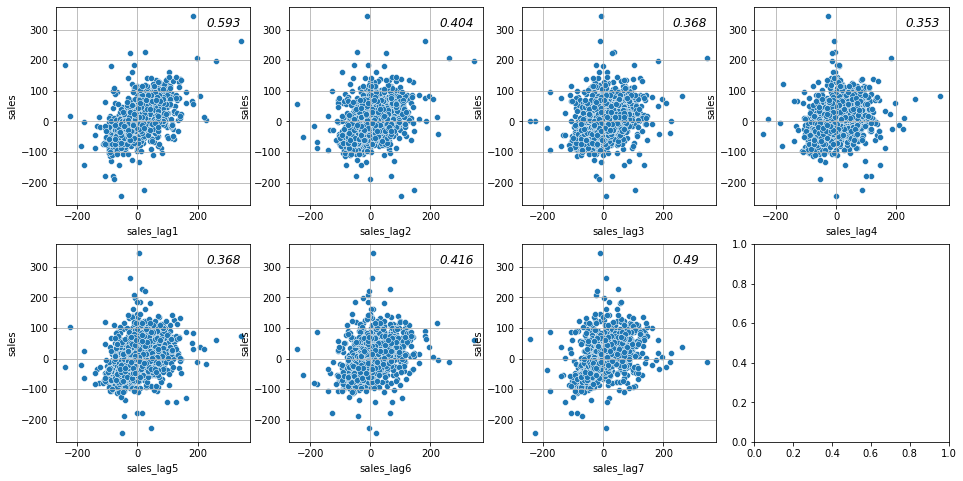

In [42]:
# Scatterplots 
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for idx, feature in enumerate(mean_sales_deseason.columns[1:]):
    k_corr = round(mean_sales_deseason[[feature, 'sales']].corr().iloc[1,0],3)
    sns.scatterplot(mean_sales_deseason[feature], mean_sales_deseason['sales'], ax=axes[idx//4, idx %4])
    axes[idx//4, idx %4].grid()
    axes[idx//4, idx %4].annotate(k_corr, xy=(230,310), fontstyle='italic', fontsize='large');

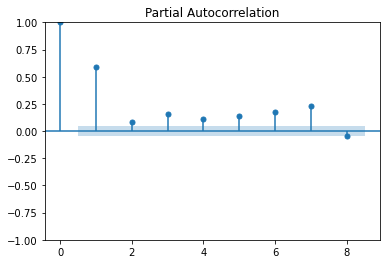

In [43]:
plot_pacf(mean_sales_deseason['sales'], lags=8);

The lag plots indicate that the relationship of *sales* to its lags is mostly linear, while the partial autocorrelations suggest the dependence can be captured using lags from 1 to 7. 

In [44]:
# data transformation
y_deseason = pd.concat([y_deseason_train, y_deseason_val], axis=0)
y_deseason = y_deseason.sort_values(by=['family','store_nbr', 'date'])
y_season = pd.concat([y_dp_fit, y_dp_pred], axis=0)
y_season = y_season.sort_values(by=['family','store_nbr', 'date'])
y_deseason.head(3)

,date,store_nbr,family,sales,onpromotion,terremoto,event_national,holiday,dcoilwtico,payday
0,2013-01-01,1,AUTOMOTIVE,0.335171,0.0,0.0,0.0,1.0,93.14,0.0
1782,2013-01-02,1,AUTOMOTIVE,-0.730053,0.0,0.0,0.0,0.0,93.14,0.0
3564,2013-01-03,1,AUTOMOTIVE,0.664302,0.0,0.0,0.0,0.0,92.97,0.0


In [45]:
y_deseason2 = y_deseason.copy()

In [46]:
# add lags
for i in range(1, 8):
    y_deseason[f'sales_lag{i}'] = y_deseason['sales'].shift(i)
y_deseason.head(8)

,date,store_nbr,family,sales,onpromotion,terremoto,event_national,holiday,dcoilwtico,payday,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,sales_lag6,sales_lag7
0,2013-01-01,1,AUTOMOTIVE,0.335171,0.0,0.0,0.0,1.0,93.14,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1782,2013-01-02,1,AUTOMOTIVE,-0.730053,0.0,0.0,0.0,0.0,93.14,0.0,0.335171,NaN,NaN,NaN,NaN,NaN,NaN
3564,2013-01-03,1,AUTOMOTIVE,0.664302,0.0,0.0,0.0,0.0,92.97,0.0,-0.730053,0.335171,NaN,NaN,NaN,NaN,NaN
5346,2013-01-04,1,AUTOMOTIVE,-0.052395,0.0,0.0,0.0,0.0,93.12,0.0,0.664302,-0.730053,0.335171,NaN,NaN,NaN,NaN
7128,2013-01-05,1,AUTOMOTIVE,2.146237,0.0,0.0,0.0,0.0,93.20,0.0,-0.052395,0.664302,-0.730053,0.335171,NaN,NaN,NaN
8910,2013-01-06,1,AUTOMOTIVE,1.557509,0.0,0.0,0.0,0.0,93.20,0.0,2.146237,-0.052395,0.664302,-0.730053,0.335171,NaN,NaN
10692,2013-01-07,1,AUTOMOTIVE,-2.136081,0.0,0.0,0.0,0.0,93.20,0.0,1.557509,2.146237,-0.052395,0.664302,-0.730053,0.335171,NaN
12474,2013-01-08,1,AUTOMOTIVE,-0.596571,0.0,0.0,0.0,0.0,93.21,0.0,-2.136081,1.557509,2.146237,-0.052395,0.664302,-0.730053,0.335171


In [47]:
# drop first 7 days without lags
y_deseason = y_deseason[(y_deseason['date']>'2013-01-07')]
y_season = y_season[(y_season['date']>'2013-01-07')]

# add periods
y_deseason['weekday'] = y_deseason['date'].dt.day_of_week
y_deseason['month'] = y_deseason['date'].dt.month

y_deseason = y_deseason.sort_values(by=['date', 'store_nbr', 'family']).reset_index()
y_season = y_season.sort_values(by=['date', 'store_nbr', 'family']).reset_index()
y_deseason = y_deseason.set_index(['date'])
y_deseason.head(3)

,index,store_nbr,family,sales,onpromotion,terremoto,event_national,holiday,dcoilwtico,payday,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,sales_lag6,sales_lag7,weekday,month
date,,,,,,,,,,,,,,,,,,,
2013-01-08,12474,1,AUTOMOTIVE,-0.596571,0.0,0.0,0.0,0.0,93.21,0.0,-2.136081,1.557509,2.146237,-0.052395,0.664302,-0.730053,0.335171,1,1
2013-01-08,12475,1,BABY CARE,0.000000,0.0,0.0,0.0,0.0,93.21,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1
2013-01-08,12476,1,BEAUTY,0.899707,0.0,0.0,0.0,0.0,93.21,0.0,-1.264705,-0.999228,0.446379,0.729452,-2.489972,-0.598483,0.157941,1,1


Let's fit binary features such as 'holiday', 'event_national' and 'payday' to deseasoned *sales*.

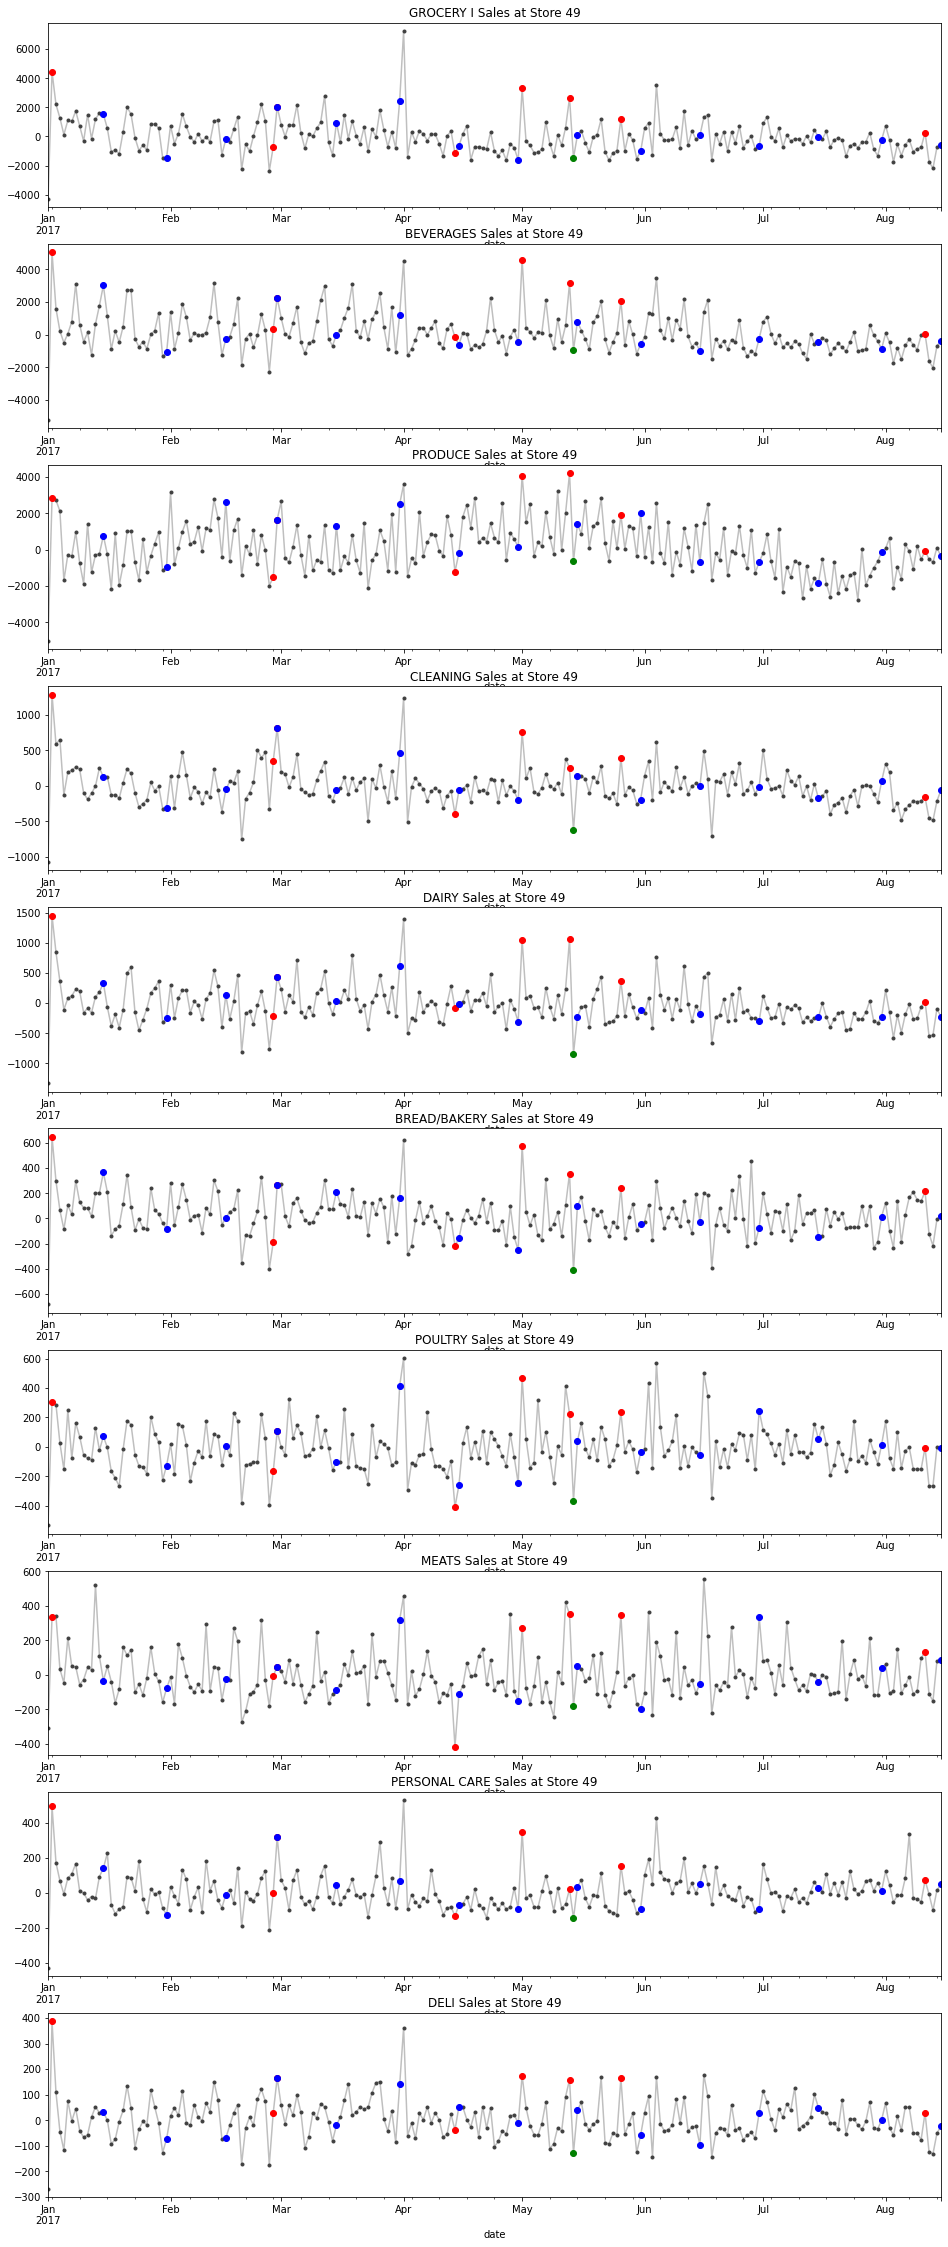

In [48]:
fig, ax = plt.subplots(nrows=len(family_top15[:10]), ncols=1,figsize=(16, 4*len(family_top15[:10])))
STORE_NBR = 49  # 1 - 54
for i, family in enumerate(family_top15[:10]):
    ax[i] = y_deseason[(y_deseason['store_nbr'] ==STORE_NBR)&(y_deseason['family'] ==family)]['2017']['sales']\
            .plot(**plot_params, ax=ax[i])
    ax[i] = y_deseason[(y_deseason['store_nbr'] ==STORE_NBR)&(y_deseason['family'] ==family)\
                       &(y_deseason['holiday'] ==1.)]['2017']['sales']\
                        .plot(color='r', style = '.', marker='o', ax=ax[i])
    ax[i] = y_deseason[(y_deseason['store_nbr'] ==STORE_NBR)&(y_deseason['family'] ==family)\
                       &(y_deseason['event_national'] ==1.)]['2017']['sales']\
                    .plot(color='g', style = '.', marker='o', ax=ax[i])
    ax[i] = y_deseason[(y_deseason['store_nbr'] ==STORE_NBR)&(y_deseason['family'] ==family)\
                       &(y_deseason['payday'] ==1.)]['2017']['sales']\
                    .plot(color='b', style = '.', marker='o', ax=ax[i])
    ax[i].set_title(f'{family} Sales at Store {STORE_NBR}');

The 'payday' seems a random feature, so we don't use it for further model fitting.

In [49]:
y_deseason = y_deseason.reset_index()
split_ind = y_deseason.loc[y_deseason['date'] == (y_deseason['date'].max() - timedelta(days=30))].head(1).index[0]

In [50]:
real_features = ['onpromotion', 'sales_lag1', 'sales_lag2', 'sales_lag3', 'sales_lag4', 'sales_lag5',
                 'sales_lag6', 'sales_lag7','dcoilwtico']
cat_features = ['store_nbr', 'family', 'weekday', 'month']
binary_features = ['event_national', 'holiday']

In [51]:
Y_deseason = y_deseason['sales'].to_numpy()
X_real = y_deseason[real_features] 
X_bin = y_deseason[binary_features]
X_cat = y_deseason[cat_features]

In [52]:
# Scaling
scaler = StandardScaler()     
scaler.fit(X_real)
X_real_scaled = scaler.transform(X_real)

# Binary transformation
enc = OneHotEncoder()
enc.fit(X_cat)
X_binary = enc.transform(X_cat).toarray()

X_deseason = np.hstack((X_real_scaled, X_bin, X_binary))
print(X_deseason.shape)

(2995542, 117)


In [53]:
# 30 days for validation
X_deseason_train = X_deseason[:split_ind, :]
X_deseason_val = X_deseason[split_ind:, :]
y_deseason_train = Y_deseason[:split_ind]
y_deseason_val = Y_deseason[split_ind:]

In [54]:
dtrain = xgb.DMatrix(data=X_deseason_train, label=y_deseason_train)
dval = xgb.DMatrix(data=X_deseason_val)

After adjusting XGBoost parameters, the best combination of learning rate, number of boost rounds and max depth was found.

In [55]:
param = {'objective': 'reg:squarederror', 
         'eta': 0.2, 
         'max_depth': 6, 
         'num_round': 60, 
         'colsample_bytree': 0.7,
         'verbosity': 0}

In [56]:
%%time
XGB_reg = xgb.train(params=param, dtrain=dtrain)
y_deseason_fit = XGB_reg.predict(dtrain)
y_deseason_pred = XGB_reg.predict(dval)

print(f'\nMSE \ntrain:{MSE(y_deseason_train, y_deseason_fit)}, test: {MSE(y_deseason_val, y_deseason_pred)}')
print(f'\nMAE \ntrain:{MAE(y_deseason_train, y_deseason_fit)}, test: {MAE(y_deseason_val, y_deseason_pred)}')


MSE 
train:50453.9664604987, test: 46263.35577306004

MAE 
train:53.702450444738545, test: 63.30737174820783
CPU times: user 6min 1s, sys: 19.7 s, total: 6min 21s
Wall time: 1min 52s


In [57]:
y_deseason['y_deseason_fit'] = np.nan
y_deseason['y_deseason_pred'] = np.nan
y_deseason.iloc[:split_ind, y_deseason.shape[1]-2] = y_deseason_fit
y_deseason.iloc[split_ind:, y_deseason.shape[1]-1] = y_deseason_pred
y_deseason = y_deseason[['date', 'store_nbr', 'family', 'sales', 'y_deseason_fit', 'y_deseason_pred']]

## 5.3. XGB + Linear Regression results

In [58]:
y = y_deseason.merge(y_season, on=['date', 'store_nbr', 'family' ], how='left', suffixes=('_deseason', '_season_fit'))
y = y.merge(data_train[['date', 'store_nbr', 'family' , 'sales']], on=['date', 'store_nbr', 'family'], how='left')
y = y.set_index(['date'])
y['sales_fit'] = y['y_deseason_fit']+y['sales_season_fit']
y['sales_pred'] = y['y_deseason_pred']+y['sales_season_fit']
y[['sales']] = y[['sales']].fillna(0)
display(y.head(3))
display(y.tail(3))

,store_nbr,family,sales_deseason,y_deseason_fit,y_deseason_pred,index,sales_season_fit,sales,sales_fit,sales_pred
date,,,,,,,,,,
2013-01-08,1,AUTOMOTIVE,-0.596571,0.310584,NaN,12474,2.596571,2.0,2.907155,NaN
2013-01-08,1,BABY CARE,0.000000,0.310584,NaN,12475,0.000000,0.0,0.310584,NaN
2013-01-08,1,BEAUTY,0.899707,0.310584,NaN,12476,2.100293,3.0,2.410877,NaN


,store_nbr,family,sales_deseason,y_deseason_fit,y_deseason_pred,index,sales_season_fit,sales,sales_fit,sales_pred
date,,,,,,,,,,
2017-08-15,54,PRODUCE,183.471666,NaN,0.310584,53457,731.899334,915.371,NaN,732.209917
2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,-2.817473,NaN,0.310584,53458,2.817473,0.000,NaN,3.128056
2017-08-15,54,SEAFOOD,0.375262,NaN,0.310584,53459,2.624738,3.000,NaN,2.935322


In [59]:
y_train = y['sales'][:split_ind]
y_val = y['sales'][split_ind:]
y_fit = y['sales_fit'][:split_ind]
y_pred = y['sales_pred'][split_ind:]

In [60]:
print(f"rmsle \ntrain:{rmsle(y_train, y_fit)}, test: {rmsle(y_val, y_pred)}")
print(f"\nMSE \ntrain:{MSE(y_train, y_fit)}, test: {MSE(y_val, y_pred)}")
print(f"\nMAE \ntrain:{MAE(y_train, y_fit)}, test: {MAE(y_val, y_pred)}")

rmsle 
train:0.9702165547927103, test: 0.5274503981268968

MSE 
train:50453.96646049869, test: 46263.35577306004

MAE 
train:53.702450444738545, test: 63.30737174820783


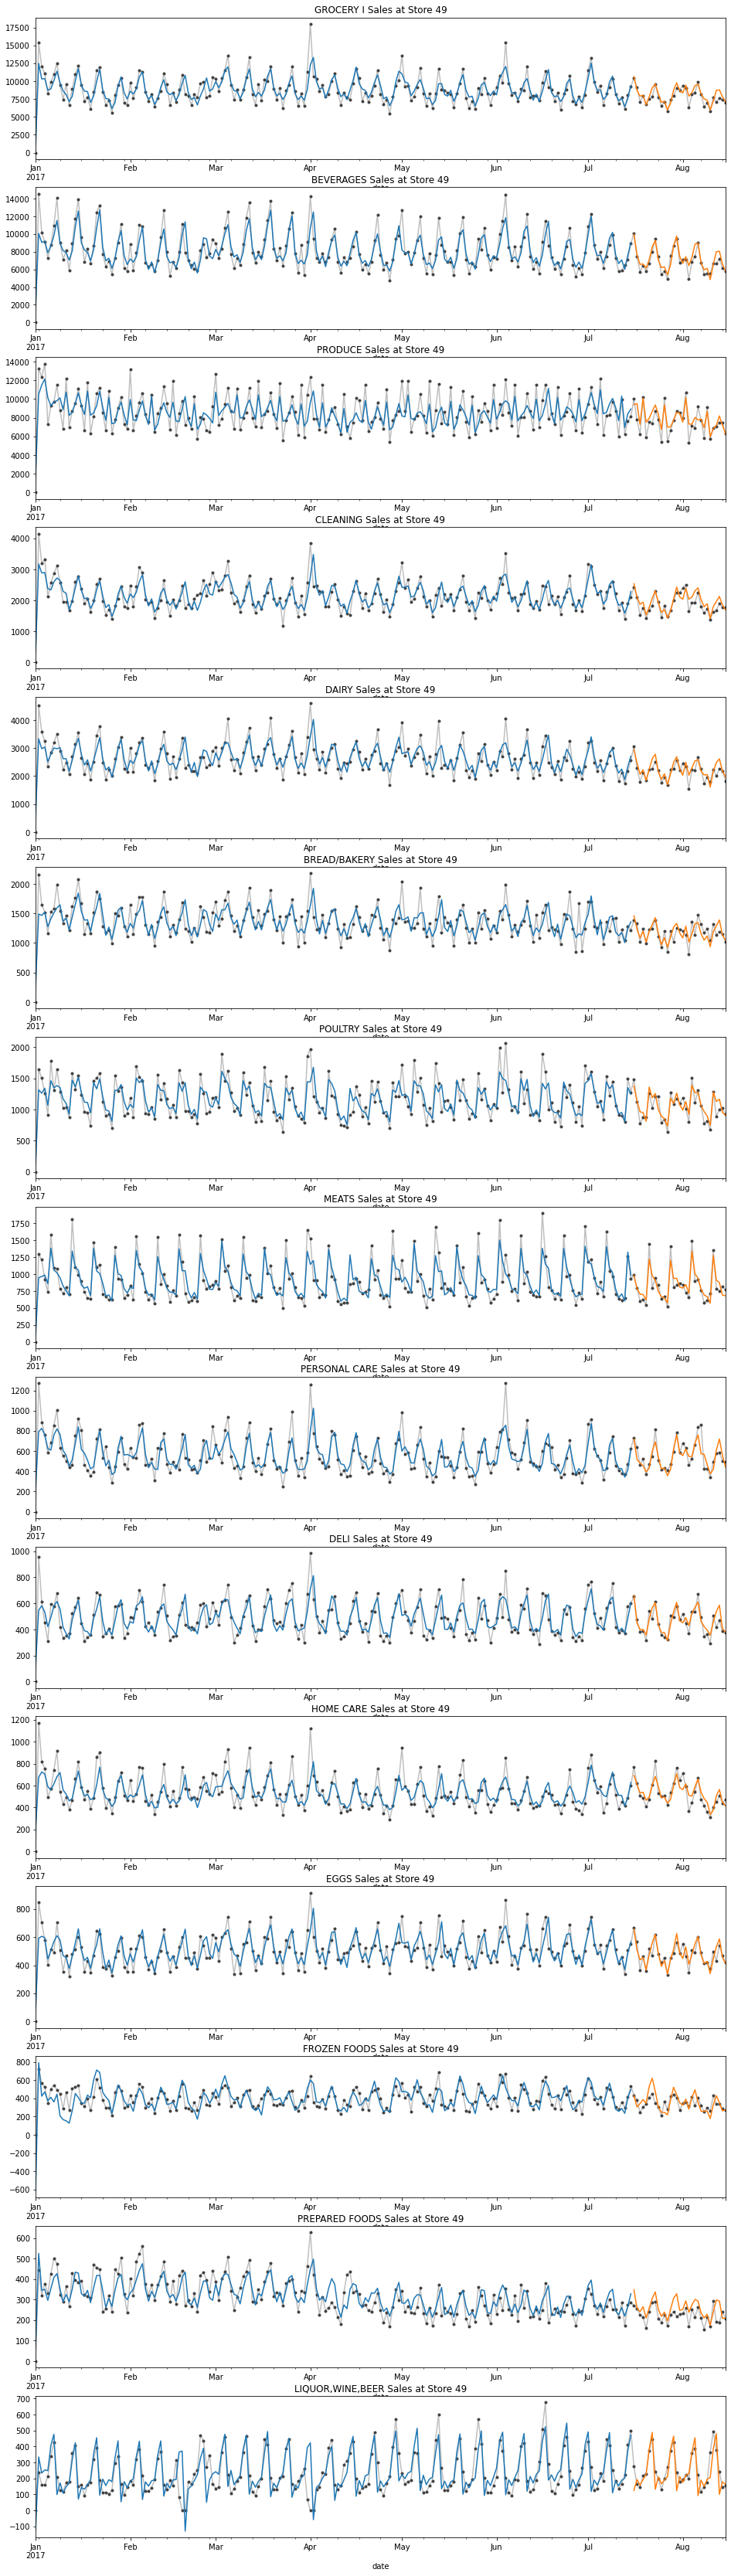

In [61]:
fig, ax = plt.subplots(nrows=len(family_top15), ncols=1,figsize=(16, 4*len(family_top15)))
STORE_NBR = 49  # 1 - 54
for i, family in enumerate(family_top15):
    ax[i] = y[(y['store_nbr'] ==STORE_NBR)&(y['family'] ==family)]['2017']['sales'].plot(**plot_params, ax=ax[i])
    ax[i] = y[(y['store_nbr'] ==STORE_NBR)&(y['family'] ==family)]['2017']['sales_fit'].plot(ax=ax[i])
    ax[i] = y[(y['store_nbr'] ==STORE_NBR)&(y['family'] ==family)]['2017']['sales_pred'].plot(ax=ax[i])
    ax[i].set_title(f'{family} Sales at Store {STORE_NBR}');

# 6. Test Forecast

In [62]:
df_test = pd.read_csv('test.csv')
df_test['date'] = pd.to_datetime(df_test['date'], errors='coerce')
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [63]:
# Create features for test set
X_dp_test = dp.out_of_sample(steps=16)
X_dp_test.index.name = 'date'
X_dp_test['new_year'] = 0

In [64]:
# get trend season predictions
y_dp_test = pd.DataFrame(model_dp.predict(X_dp_test), index=X_dp_test.index, columns=y_dp.columns)
y_dp_test = y_dp_test.stack(['store_nbr', 'family'])
y_dp_test = y_dp_test.join(df_test.id).reindex(columns=['id', 'sales'])
y_dp_test.head()

id        sales
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888     4.012718
                     BABY CARE   3000889     0.000000
                     BEAUTY      3000890     3.965777
                     BEVERAGES   3000891  2272.032284
                     BOOKS       3000892     0.874962

In [65]:
df_test = pd.read_csv('test.csv', index_col='id')
df_test = df_test.sort_values(by=['family',  'store_nbr', 'date'])
df_test.head(3)

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,20.0
3002670,2017-08-17,1,AUTOMOTIVE,20.0
3004452,2017-08-18,1,AUTOMOTIVE,20.0


In [66]:
# Add features

# add cities 
data_test= df_test.merge(
    df_stores[['city', 'state', 'type', 'cluster','store_nbr']], on=['store_nbr'], how = 'left')

# add terremoto feature
data_test = data_test.merge(
    df_hol[df_hol['terremoto']==True][['date','terremoto']], on = ['date'], how = 'left')

# add national events
data_test = data_test.merge(
    df_hol[df_hol['event_national']==True][['date', 'event_national']], on = ['date'], how = 'left')

# add national holidays 
data_test = data_test.merge(
    df_hol[df_hol['holiday_national']==True][['date', 'holiday_national']], on = ['date'], how = 'left')

# add regional holidays
data_test = data_test.merge(
    df_hol[df_hol['holiday_regional']==True][['date','holiday_regional', 'locale_name']], 
    left_on = ['date', 'state'], right_on = ['date', 'locale_name'], how = 'left')

# add local holidays
data_test = data_test.merge(
    df_hol[df_hol['holiday_local']==True][['date','holiday_local', 'locale_name']], 
                              left_on = ['date', 'city'], right_on = ['date', 'locale_name'], how = 'left')

data_test.drop_duplicates(ignore_index=True, inplace=True)

# marks as holiday if there is at least 1 holiday
data_test.loc[
    (data_test['holiday_national']==1)|(data_test['holiday_regional']==1)|(data_test['holiday_local']==1),
    'holiday'] = 1

data_test.drop(columns=['holiday_national', 'holiday_regional', 'holiday_local', 
                         'locale_name_x', 'locale_name_y', 'state'], inplace=True)

# fill the gaps
data_test.fillna(0, inplace=True)

# add oil prices
data_test = data_test.merge(df_oil, on = ['date'], how = 'left')
data_test['dcoilwtico'].fillna(method='bfill', inplace=True)

data_test.drop(columns=['city', 'type', 'cluster'], inplace=True)

data_test['date'] = pd.to_datetime(data_test['date'], errors='coerce')
data_test['date'] = data_test['date'].dt.to_period('D')

data_test.head(3)

,date,store_nbr,family,onpromotion,terremoto,event_national,holiday,dcoilwtico
0,2017-08-16,1,AUTOMOTIVE,20.0,0.0,0.0,0.0,46.80
1,2017-08-17,1,AUTOMOTIVE,20.0,0.0,0.0,0.0,47.07
2,2017-08-18,1,AUTOMOTIVE,20.0,0.0,0.0,0.0,48.59


In [67]:
y_deseason2.head(3)

,date,store_nbr,family,sales,onpromotion,terremoto,event_national,holiday,dcoilwtico,payday
0,2013-01-01,1,AUTOMOTIVE,0.335171,0.0,0.0,0.0,1.0,93.14,0.0
1782,2013-01-02,1,AUTOMOTIVE,-0.730053,0.0,0.0,0.0,0.0,93.14,0.0
3564,2013-01-03,1,AUTOMOTIVE,0.664302,0.0,0.0,0.0,0.0,92.97,0.0


In [68]:
y_deseason2.drop(columns=['payday'], inplace=True)

In [69]:
# concat train and test to get lags for test
y_deseason2= pd.concat([y_deseason2, data_test], axis=0)
y_deseason2 = y_deseason2.sort_values(by=['family',  'store_nbr', 'date'])

# add lags
for i in range(1, 8):
    y_deseason2[f'sales_lag{i}'] = y_deseason2['sales'].shift(i)
y_deseason2.head(8)

,date,store_nbr,family,sales,onpromotion,terremoto,event_national,holiday,dcoilwtico,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,sales_lag6,sales_lag7
0,2013-01-01,1,AUTOMOTIVE,0.335171,0.0,0.0,0.0,1.0,93.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1782,2013-01-02,1,AUTOMOTIVE,-0.730053,0.0,0.0,0.0,0.0,93.14,0.335171,NaN,NaN,NaN,NaN,NaN,NaN
3564,2013-01-03,1,AUTOMOTIVE,0.664302,0.0,0.0,0.0,0.0,92.97,-0.730053,0.335171,NaN,NaN,NaN,NaN,NaN
5346,2013-01-04,1,AUTOMOTIVE,-0.052395,0.0,0.0,0.0,0.0,93.12,0.664302,-0.730053,0.335171,NaN,NaN,NaN,NaN
7128,2013-01-05,1,AUTOMOTIVE,2.146237,0.0,0.0,0.0,0.0,93.20,-0.052395,0.664302,-0.730053,0.335171,NaN,NaN,NaN
8910,2013-01-06,1,AUTOMOTIVE,1.557509,0.0,0.0,0.0,0.0,93.20,2.146237,-0.052395,0.664302,-0.730053,0.335171,NaN,NaN
10692,2013-01-07,1,AUTOMOTIVE,-2.136081,0.0,0.0,0.0,0.0,93.20,1.557509,2.146237,-0.052395,0.664302,-0.730053,0.335171,NaN
12474,2013-01-08,1,AUTOMOTIVE,-0.596571,0.0,0.0,0.0,0.0,93.21,-2.136081,1.557509,2.146237,-0.052395,0.664302,-0.730053,0.335171


In [70]:
# return test part
y_deseason_test = y_deseason2[(y_deseason2['date'] > '2017-08-15')]
y_deseason_test.head(8)

,date,store_nbr,family,sales,onpromotion,terremoto,event_national,holiday,dcoilwtico,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,sales_lag6,sales_lag7
0,2017-08-16,1,AUTOMOTIVE,NaN,20.0,0.0,0.0,0.0,46.80,-0.442195,-2.949415,-1.153852,1.565398,-3.533523,5.195526,2.695383
1,2017-08-17,1,AUTOMOTIVE,NaN,20.0,0.0,0.0,0.0,47.07,NaN,-0.442195,-2.949415,-1.153852,1.565398,-3.533523,5.195526
2,2017-08-18,1,AUTOMOTIVE,NaN,20.0,0.0,0.0,0.0,48.59,NaN,NaN,-0.442195,-2.949415,-1.153852,1.565398,-3.533523
3,2017-08-19,1,AUTOMOTIVE,NaN,20.0,0.0,0.0,0.0,47.39,NaN,NaN,NaN,-0.442195,-2.949415,-1.153852,1.565398
4,2017-08-20,1,AUTOMOTIVE,NaN,20.0,0.0,0.0,0.0,47.39,NaN,NaN,NaN,NaN,-0.442195,-2.949415,-1.153852
5,2017-08-21,1,AUTOMOTIVE,NaN,20.0,0.0,0.0,0.0,47.39,NaN,NaN,NaN,NaN,NaN,-0.442195,-2.949415
6,2017-08-22,1,AUTOMOTIVE,NaN,20.0,0.0,0.0,0.0,47.65,NaN,NaN,NaN,NaN,NaN,NaN,-0.442195
7,2017-08-23,1,AUTOMOTIVE,NaN,20.0,0.0,0.0,0.0,48.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
# add periods
y_deseason_test['weekday'] = y_deseason_test['date'].dt.day_of_week
y_deseason_test['month'] = y_deseason_test['date'].dt.month

In [72]:
test_dates = y_deseason_test['date'].unique()

The forecast horizon for the test data is 16 days. Hovewer we have *1-lag* only for the first day, *2-lag* for the first 2 days and so on. The recursive strategy will be used: we will train a single one-step model and use its forecasts to update the lag features for the next step. 

In [73]:
for i in range(len(test_dates)): 
    
    X_real = y_deseason_test[y_deseason_test['date']==test_dates[i]][real_features]
    X_cat = y_deseason_test[y_deseason_test['date']==test_dates[i]][cat_features]
    X_bin = y_deseason_test[y_deseason_test['date']==test_dates[i]][binary_features]

    # Scaling and Binary transformation
    X_real_scaled = scaler.transform(X_real)
    X_binary = enc.transform(X_cat).toarray()
    X_test = np.hstack((X_real_scaled, X_bin, X_binary))

    # Forecast for 1 step
    dtest = xgb.DMatrix(data=X_test)
    y_pred_future = XGB_reg.predict(dtest)

    X_real['y_pred'] = y_pred_future
    y_deseason_test = y_deseason_test.join(X_real[['y_pred']])

    for i in range(1, 8):
        y_deseason_test[f'y_pred_lag{i}'] = y_deseason_test['sales'].shift(i)
        y_deseason_test[f'sales_lag{i}'] = y_deseason_test[f'sales_lag{i}']\
                        .combine_first(y_deseason_test[f'y_pred_lag{i}'])
        
    y_deseason_test['sales'] = y_deseason_test['sales'].combine_first(y_deseason_test['y_pred'])
    y_deseason_test.drop(columns=['y_pred', 'y_pred_lag1', 'y_pred_lag2', 'y_pred_lag3',
                         'y_pred_lag4', 'y_pred_lag5', 'y_pred_lag6','y_pred_lag7'], inplace=True)
    

In [74]:
y_deseason_test = y_deseason_test.set_index('date')

In [75]:
y_deseason_test.rename(columns={'sales':'sales_deseason'}, inplace=True)
y_deseason_test = y_deseason_test.reset_index()
y_deseason_test.head()

,date,store_nbr,family,sales_deseason,onpromotion,terremoto,event_national,holiday,dcoilwtico,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,sales_lag6,sales_lag7,weekday,month
0,2017-08-16,1,AUTOMOTIVE,0.310584,20.0,0.0,0.0,0.0,46.80,-0.442195,-2.949415,-1.153852,1.565398,-3.533523,5.195526,2.695383,2,8
1,2017-08-17,1,AUTOMOTIVE,-967.075806,20.0,0.0,0.0,0.0,47.07,0.310584,-0.442195,-2.949415,-1.153852,1.565398,-3.533523,5.195526,3,8
2,2017-08-18,1,AUTOMOTIVE,-1053.570068,20.0,0.0,0.0,0.0,48.59,-967.075806,0.310584,-0.442195,-2.949415,-1.153852,1.565398,-3.533523,4,8
3,2017-08-19,1,AUTOMOTIVE,-1053.570068,20.0,0.0,0.0,0.0,47.39,-1053.570068,-967.075806,0.310584,-0.442195,-2.949415,-1.153852,1.565398,5,8
4,2017-08-20,1,AUTOMOTIVE,-2005.964844,20.0,0.0,0.0,0.0,47.39,-1053.570068,-1053.570068,-967.075806,0.310584,-0.442195,-2.949415,-1.153852,6,8


In [76]:
y_dp_test = y_dp_test.reset_index()
y_dp_test.rename(columns={'sales':'sales_season'}, inplace=True)
y_dp_test.head(3)

,date,store_nbr,family,id,sales_season
0,2017-08-16,1,AUTOMOTIVE,3000888,4.012718
1,2017-08-16,1,BABY CARE,3000889,0.000000
2,2017-08-16,1,BEAUTY,3000890,3.965777


In [77]:
y_test = y_dp_test.merge(y_deseason_test[['date', 'store_nbr', 'family', 'sales_deseason']],
                             on=['date', 'store_nbr', 'family'])
y_test = y_test.sort_values(by='id')

# get forecast sales
y_test['sales'] = y_test['sales_season'] + y_test['sales_deseason']
y_plot = y_test.set_index('date')
y_test.loc[y_test['sales']<0, 'sales']=0.0
y_test.head(3)

,date,store_nbr,family,id,sales_season,sales_deseason,sales
0,2017-08-16,1,AUTOMOTIVE,3000888,4.012718,0.310584,4.323301
1,2017-08-16,1,BABY CARE,3000889,0.000000,0.310584,0.310584
2,2017-08-16,1,BEAUTY,3000890,3.965777,0.310584,4.276360
